<a href="https://colab.research.google.com/github/So-nja/Keras_example_study_2023/blob/main/Computer_Vision/Simple_MNIST_convnet(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#단순한 MNIST CNN(합성곱 신경망) 

*이 문서는 keras 예제를 분석하여 Pytorch framework로 적용한 것입니다.*

<br>[예제 페이지](https://keras.io/examples/vision/mnist_convnet/)
<br>[이전에 분석한 내용](https://github.com/So-nja/Keras_example_study_2023/blob/main/Computer_Vision/Simple_MNIST_convnet.ipynb)
<br>[Pytorch 참고](https://wikidocs.net/63565)
<br>
<br>



In [1]:
#colab 에서의 파이토치 초기 설정
!pip3 install torch
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

import PIL
from matplotlib import pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)

if device == 'cuda':
  torch.cuda.manual_seed_all(777)

#하이퍼파라미터

In [4]:
learning_rate = 0.001
training_epochs = 15
batch_size = 128

#데이터셋 정의

In [5]:
train_data = dsets.MNIST(root='data/', 
                         train=True, 
                         transform=transforms.ToTensor(), 
                         download=True)

test_data = dsets.MNIST(root='data/', 
                         train=False, 
                         transform=transforms.ToTensor(), 
                         download=True)

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

image, label = train_data[0]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

number of training data:  60000
number of test data:  10000


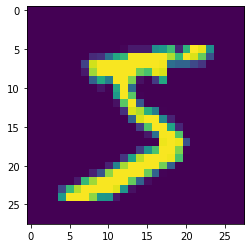

In [6]:
plt.imshow(image.squeeze().numpy())
plt.show()

In [7]:
data_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                          batch_size= batch_size, 
                                          shuffle=True, 
                                          drop_last=True)

#CNN 모델 생성

In [8]:
class CNN(torch.nn.Module):
      
      def __init__(self):
        super(CNN, self).__init__()
        #첫번째 레이어
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        #두번째 레이어
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(0.5)
        self.dense = torch.nn.Linear(7 * 7 * 64, 10, bias=True)


      def forward(self, x):
          out = self.layer1(x)
          out = self.layer2(out)
          #out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
          out = self.flatten(out)
          out = self.dropout(out)
          #out = self.dense(out)
          return self.dense(out)

In [9]:
#CNN 모델 정의
model = CNN().to(device)

#loss function, optimizer 정의
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 468


#Training

In [10]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.281444252
[Epoch:    2] cost = 0.0898190066
[Epoch:    3] cost = 0.0713311583
[Epoch:    4] cost = 0.0604172051
[Epoch:    5] cost = 0.053621497
[Epoch:    6] cost = 0.0503034294
[Epoch:    7] cost = 0.0462227128
[Epoch:    8] cost = 0.0429894961
[Epoch:    9] cost = 0.0381467678
[Epoch:   10] cost = 0.0368071049
[Epoch:   11] cost = 0.033710409
[Epoch:   12] cost = 0.0336673968
[Epoch:   13] cost = 0.0299147889
[Epoch:   14] cost = 0.0312058721
[Epoch:   15] cost = 0.0269207023


#Test

In [11]:
with torch.no_grad():   #학습을 진행하지 않으므로 torch.no_grad()
    X_test = test_data.data.view(len(test_data), 1, 28, 28).float().to(device)
    Y_test = test_data.targets.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9661999940872192
